In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

# Named Entity Recognition (NER)

NER is an information extraction technique to identify and classify named entities in text. These entities can be pre-defined and generic like location names, organizations, time and etc, or they can be very specific like the example with the resume.

The goal of a named entity recognition (NER) system is to identify all textual mentions of the named entities. This can be broken down into two sub-tasks: identifying the boundaries of the NE, and identifying its type.

Named entity recognition is a task that is well-suited to the type of classifier-based approach. In particular, a tagger can be built that labels each word in a sentence using the IOB format, where chunks are labelled by their appropriate type.

The IOB Tagging system contains tags of the form:

* B - {CHUNK_TYPE} – for the word in the Beginning chunk
* I - {CHUNK_TYPE} – for words Inside the chunk
* O – Outside any chunk

The IOB tags are further classified into the following classes –

* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

## Approaches to NER
* **Classical Approaches:** mostly rule-based.
* **Machine Learning Approaches:** there are two main methods in this category: 
    * Treat the problem as a multi-class classification where named entities are our labels so we can apply different classification algorithms. The problem here is that identifying and labeling named entities require thorough understanding of the context of a sentence and sequence of the word labels in it, which this method ignores that.
    * Conditional Random Field (CRF) model. It is a probabilistic graphical model that can be used to model sequential data such as labels of words in a sentence. The CRF model is able to capture the features of the current and previous labels in a sequence but it cannot understand the context of the forward labels; this shortcoming plus the extra feature engineering involved with training a CRF model, makes it less appealing to be adapted by the industry.
* **Deep Learning Approaches:** Bidirectional RNNs

# EDA

In [2]:
data = pd.read_csv(
    "../input/entity-annotated-corpus/ner.csv", encoding = "ISO-8859-1", error_bad_lines=False, 
    usecols=['sentence_idx', 'word', 'tag']
)
data  = data[data['sentence_idx'] != 'prev-lemma'].dropna(subset=['sentence_idx']).reset_index(drop=True)
print(data.shape)
data.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(1050794, 3)


,sentence_idx,word,tag
0,1,Thousands,O
1,1,of,O
2,1,demonstrators,O
3,1,have,O
4,1,marched,O


**Create list of list of tuples to differentiate each sentence from each other**

In [3]:
class SentenceGetter(object):
    
    def __init__(self, dataset, word_col, tag_col, sent_id_col):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [
            (w, t) for w,t in zip(s[word_col].values.tolist(), s[tag_col].values.tolist())
        ]
        self.grouped = self.dataset.groupby(sent_id_col).apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [4]:
getter = SentenceGetter(dataset=data, word_col='word', tag_col='tag', sent_id_col='sentence_idx')
sentences = getter.sentences
print(sentences[0])

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


Number of Sentences: 36684
Maximum sequence length: 140
Number of unique words: 30173


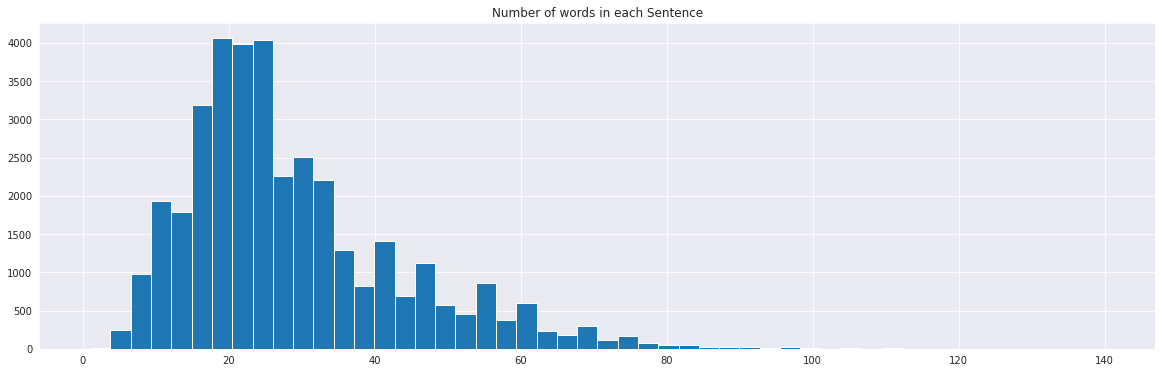

In [5]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.hist([len(s) for s in sentences], bins=50)
ax.set_title('Number of words in each Sentence')

maxlen = max([len(s) for s in sentences])
print('Number of Sentences:', len(sentences))
print ('Maximum sequence length:', maxlen)

words = list(set(data["word"].values))
words.append("ENDPAD")
n_words = len(words)
print('Number of unique words:', n_words)

Number of unique Tags: 17


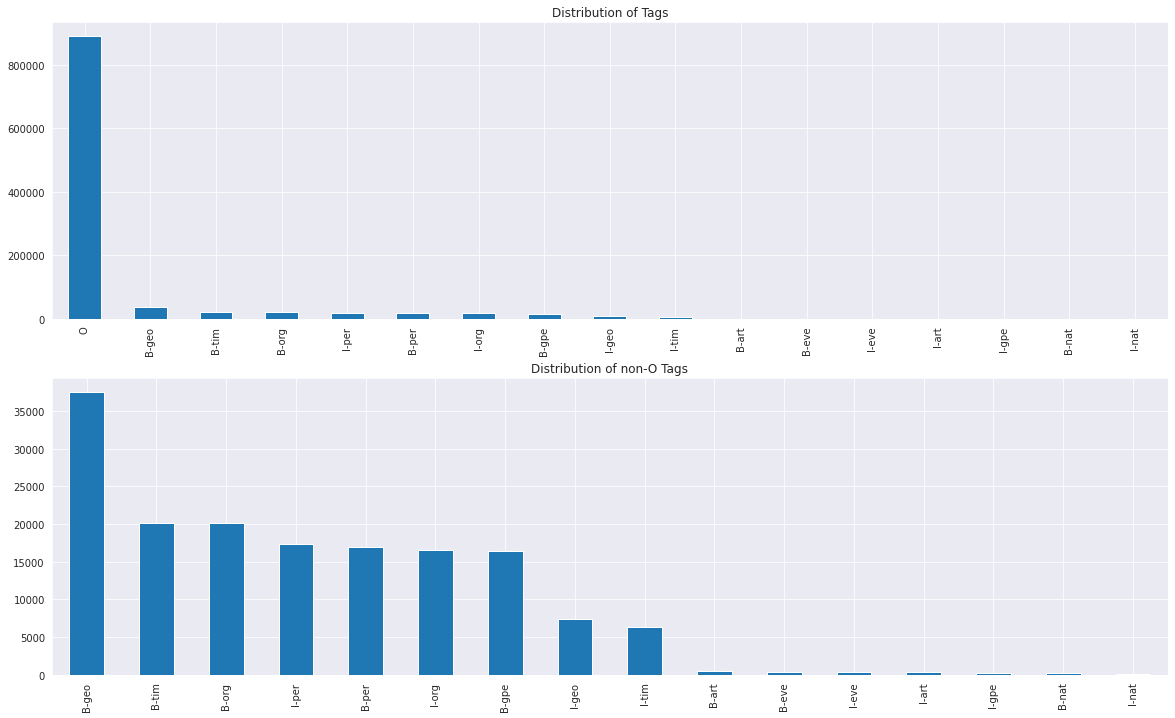

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
data.tag.value_counts().plot.bar(ax=ax[0], title='Distribution of Tags')
data[data.tag != 'O'].tag.value_counts().plot.bar(ax=ax[1], title='Distribution of non-O Tags')

tags = list(set(data["tag"].values))
n_tags = len(tags)
print('Number of unique Tags:', n_tags)

**Converting words to numbers and numbers to words**

In [7]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

# Modelling

In [8]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as L
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical

In [9]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = sequence.pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = sequence.pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"])
y = np.array([to_categorical(i, num_classes=n_tags) for i in y])

print('X shape', X.shape, 'y shape', y.shape)

X shape (36684, 140) y shape (36684, 140, 17)


In [10]:
class config():
    VOCAB = n_words
    MAX_LEN = maxlen
    N_OUPUT = n_tags
    
    
    EMBEDDING_VECTOR_LENGTH = 50
    DENSE_DIM = 32
    NUM_HEADS = 2
    
    OUTPUT_ACTIVATION = 'softmax'
    
    LOSS = 'categorical_crossentropy'
    OPTIMIZER = 'adam'
    METRICS = ['accuracy']
    
    MAX_EPOCHS = 10
    

In [11]:
class PositionalEmbedding(L.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = L.Embedding(input_dim, output_dim)
        self.position_embeddings = L.Embedding(sequence_length, output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config
    
class TransformerEncoder(L.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = L.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([L.Dense(dense_dim, activation='relu'), L.Dense(embed_dim)])
        self.layernorm1 = L.LayerNormalization()
        self.layernorm2 = L.LayerNormalization()
    
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[: tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm2(proj_input + proj_output)
    
    def get_config(self):
        config = super().get_confog()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim
        })
        return config    

2021-12-22 16:49:19.773148: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-22 16:49:19.858017: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-22 16:49:19.858778: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-22 16:49:19.860438: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
positional_embedding (Positi (None, None, 50)          1515650   
_________________________________________________________________
transformer_encoder (Transfo (None, None, 50)          23832     
_________________________________________________________________
dropout (Dropout)            (None, None, 50)          0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 17)          867       
Total params: 1,540,349
Trainable params: 1,540,349
Non-trainable params: 0
_________________________________________________________________


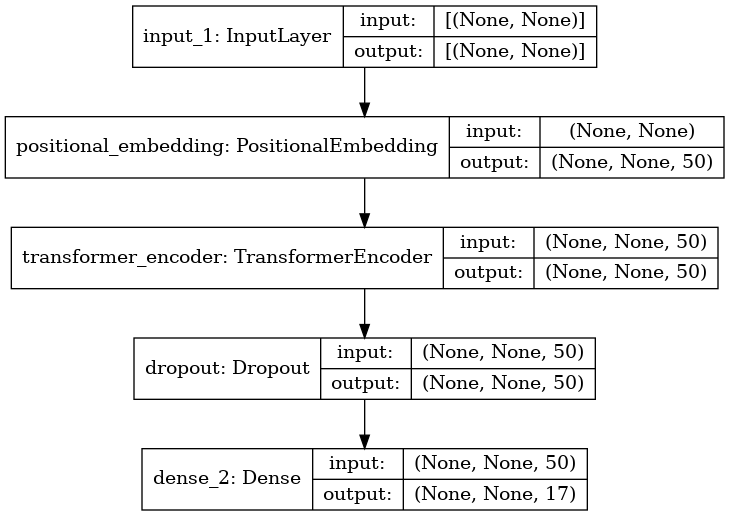

In [12]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)

inputs = keras.Input(shape=(None, ), dtype="int64")
x = PositionalEmbedding(config.MAX_LEN, config.VOCAB, config.EMBEDDING_VECTOR_LENGTH)(inputs)
x = TransformerEncoder(config.EMBEDDING_VECTOR_LENGTH, config.DENSE_DIM, config.NUM_HEADS)(x)
x = L.Dropout(0.5)(x)
outputs = L.Dense(config.N_OUPUT, activation=config.OUTPUT_ACTIVATION)(x)

model = keras.Model(inputs, outputs)
model.compile(loss=config.LOSS, optimizer=config.OPTIMIZER, metrics=config.METRICS)

model.summary()
plot_model(model, show_shapes=True)

In [13]:
history = model.fit(x=X, y=y, validation_split=0.1,
    callbacks=[es, rlp], epochs=config.MAX_EPOCHS
)

2021-12-22 16:49:23.769223: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
   8/1032 [..............................] - ETA: 8s - loss: 2.2634 - accuracy: 0.4741   

2021-12-22 16:49:26.601285: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1032/1032 [==============================] - 12s 8ms/step - loss: 0.0952 - accuracy: 0.9793 - val_loss: 0.0310 - val_accuracy: 0.9917
Epoch 2/10
1032/1032 [==============================] - 8s 8ms/step - loss: 0.0382 - accuracy: 0.9894 - val_loss: 0.0280 - val_accuracy: 0.9921
Epoch 3/10
1032/1032 [==============================] - 8s 8ms/step - loss: 0.0315 - accuracy: 0.9908 - val_loss: 0.0268 - val_accuracy: 0.9925
Epoch 4/10
1032/1032 [==============================] - 8s 8ms/step - loss: 0.0282 - accuracy: 0.9915 - val_loss: 0.0257 - val_accuracy: 0.9924
Epoch 5/10
1032/1032 [==============================] - 8s 8ms/step - loss: 0.0252 - accuracy: 0.9922 - val_loss: 0.0264 - val_accuracy: 0.9930
Epoch 6/10
1032/1032 [==============================] - 8s 8ms/step - loss: 0.0222 - accuracy: 0.9930 - val_loss: 0.0253 - val_accuracy: 0.9930
Epoch 7/10
1032/1032 [==============================] - 8s 8ms/step - loss: 0.0195 - accuracy: 0.9938 - val_loss: 0.0256 - val_accuracy: 0.9932
Ep

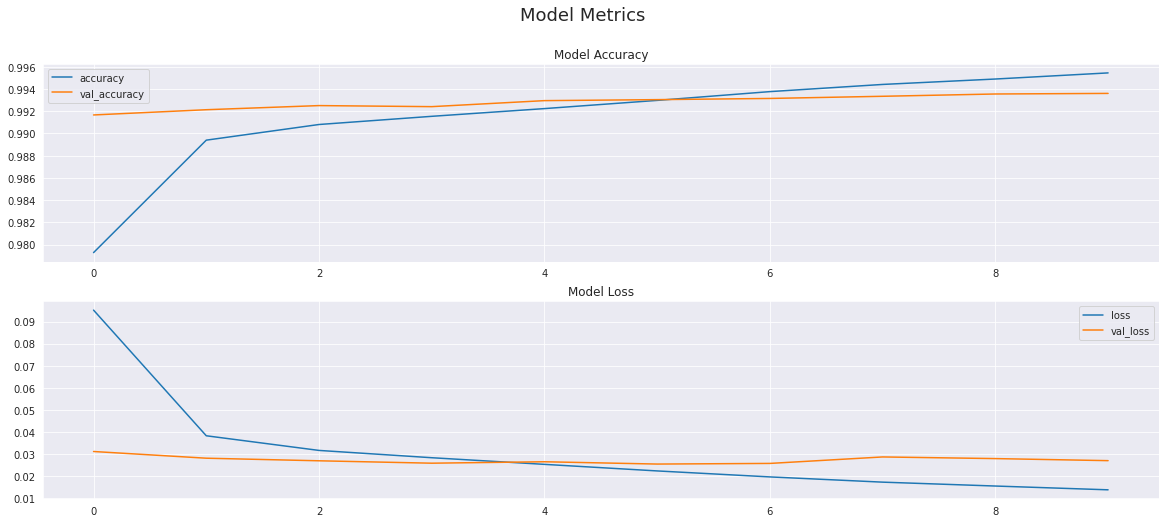

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8))
df = pd.DataFrame(history.history)
df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
df[['loss', 'val_loss']].plot(ax=ax[1])
ax[0].set_title('Model Accuracy', fontsize=12)
ax[1].set_title('Model Loss', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18);

In [15]:
i = np.random.randint(0, X.shape[0])
p = model.predict(np.array([X[i]]))
p = np.argmax(p, axis=-1)
y_true = np.argmax(y, axis=-1)[i]

print(f"{'Word':15}{'True':5}\t{'Pred'}")
print("-"*30)
for (w, t, pred) in zip(X[i], y_true, p[0]):
    print(f"{words[w]:15}{tags[t]}\t{tags[pred]}")
    if words[w] == 'ENDPAD': 
        break

Word           True 	Pred
------------------------------
She            O	O
has            O	O
played         O	O
Groenefeld     B-per	B-per
once           O	O
before         B-tim	O
-              I-tim	O
earlier        O	O
this           O	O
year           O	O
in             O	O
Stanford       B-geo	B-geo
,              O	O
California     B-geo	B-geo
-              O	O
and            O	O
beat           O	O
the            O	O
German         B-gpe	B-gpe
player         O	O
in             O	O
straight       O	O
sets           O	O
.              O	O
She            O	O
has            O	O
played         O	O
Groenefeld     B-per	B-per
once           O	O
before         B-tim	O
-              I-tim	O
earlier        O	O
this           O	O
year           O	O
in             O	O
Stanford       B-geo	B-geo
,              O	O
California     B-geo	B-geo
-              O	O
and            O	O
beat           O	O
the            O	O
German         B-gpe	B-gpe
player         O	O
in             O	O
straight